# Import libraries

In [1]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Mounted at /content/drive


# Load Dataset

In [2]:
file_path = "/content/drive/MyDrive/student_prediction.csv"
df = pd.read_csv(file_path)

# Data Cleaning

In [3]:
df = df.drop(columns=['Student_ID'])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Student_Age         645 non-null    int64  
 1   Sex                 645 non-null    object 
 2   High_School_Type    645 non-null    object 
 3   Scholarship         645 non-null    object 
 4   A6itional_Work      645 non-null    object 
 5   Sports_activity     645 non-null    object 
 6   Transportation      645 non-null    object 
 7   Weekly_Study_Hours  645 non-null    int64  
 8   Attendance          645 non-null    object 
 9   Reading             645 non-null    object 
 10  Notes               645 non-null    object 
 11  Listening_in_Class  645 non-null    object 
 12  Project_work        645 non-null    object 
 13  Grade               645 non-null    float64
dtypes: float64(1), int64(2), object(11)
memory usage: 70.7+ KB
None
   Student_Age     Sex High_School_Type Sc

#Basic Visualization

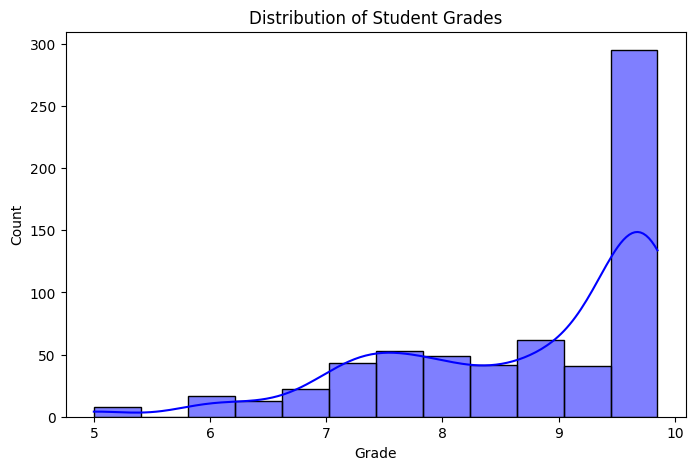

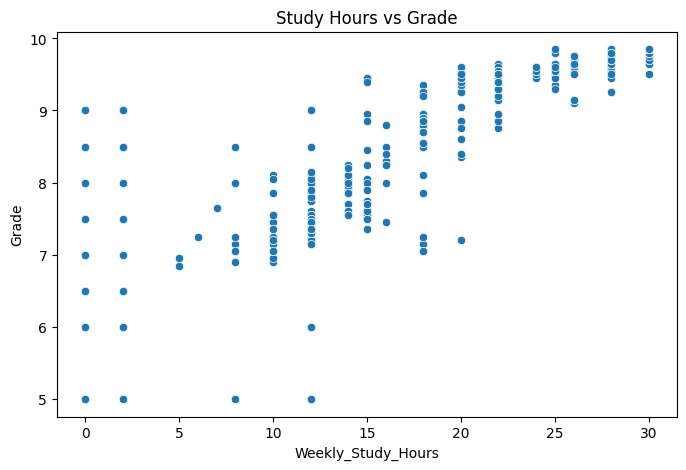

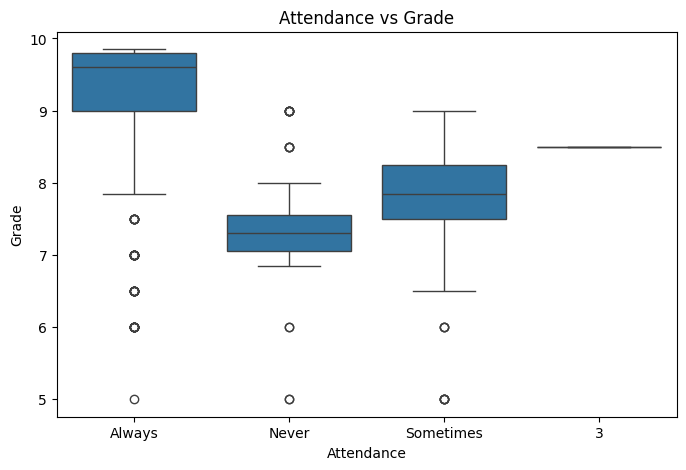

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['Grade'], kde=True, color="blue")
plt.title("Distribution of Student Grades")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Weekly_Study_Hours', y='Grade', data=df)
plt.title("Study Hours vs Grade")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Attendance', y='Grade', data=df)
plt.title("Attendance vs Grade")
plt.show()

# Define Features

In [6]:
X = df.drop(columns=['Grade'])
y = df['Grade']

categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

#Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Linear Regression

In [8]:

lin_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(" MAE:", mae)
    print(" RMSE:", rmse)
    print(" R²:", r2)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
results.append(evaluate(y_test, y_pred_lin, "Linear Regression"))


Linear Regression Performance:
 MAE: 0.3562887189790379
 RMSE: 0.5643974398937998
 R²: 0.7738444438130481


# Feature Importance

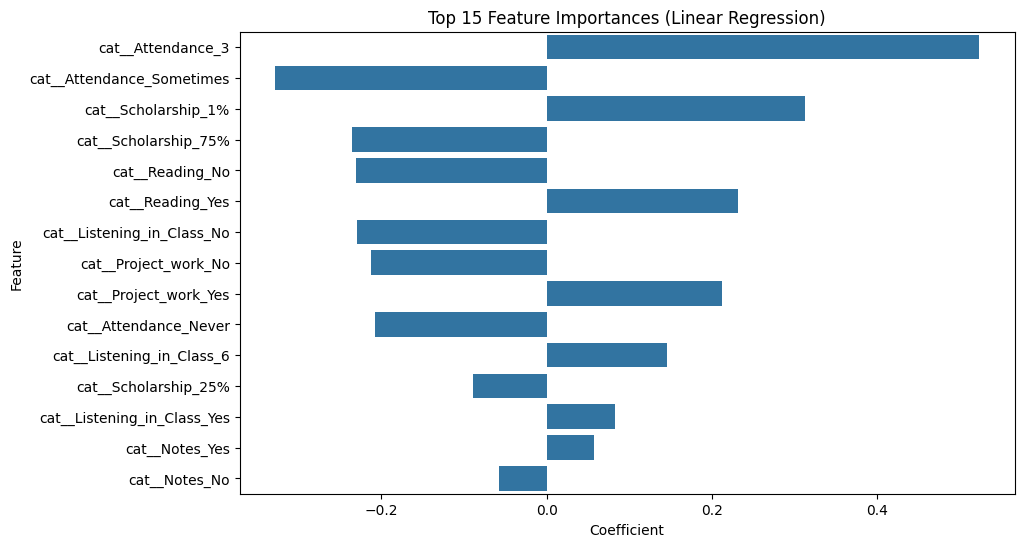

In [9]:
feature_names = lin_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = lin_model.named_steps['regressor'].coef_

importance_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
importance_df = importance_df.sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=importance_df.head(15))
plt.title("Top 15 Feature Importances (Linear Regression)")
plt.show()

# Polynomial Regression

In [10]:
poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

results.append(evaluate(y_test, y_pred_poly, "Polynomial Regression (degree=2)"))


Polynomial Regression (degree=2) Performance:
 MAE: 0.4102872795811414
 RMSE: 0.7054455619852453
 R²: 0.646683269483195


# Experiment: Feature Subset

In [11]:
X_num = df[numeric_features]
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y, test_size=0.2, random_state=42)

num_model = LinearRegression()
num_model.fit(X_train_num, y_train_num)
y_pred_num = num_model.predict(X_test_num)

results.append(evaluate(y_test_num, y_pred_num, "Linear Regression (Only Numeric Features)"))


Linear Regression (Only Numeric Features) Performance:
 MAE: 0.48909419389860104
 RMSE: 0.6944751775849792
 R²: 0.657586683037856


# Comparison Table

In [12]:
results_df = pd.DataFrame(results)
print("\n Model Comparison:")
print(results_df)


 Model Comparison:
                                       Model       MAE      RMSE        R2
0                          Linear Regression  0.356289  0.564397  0.773844
1           Polynomial Regression (degree=2)  0.410287  0.705446  0.646683
2  Linear Regression (Only Numeric Features)  0.489094  0.694475  0.657587


# Visualization: Actual vs Predicted

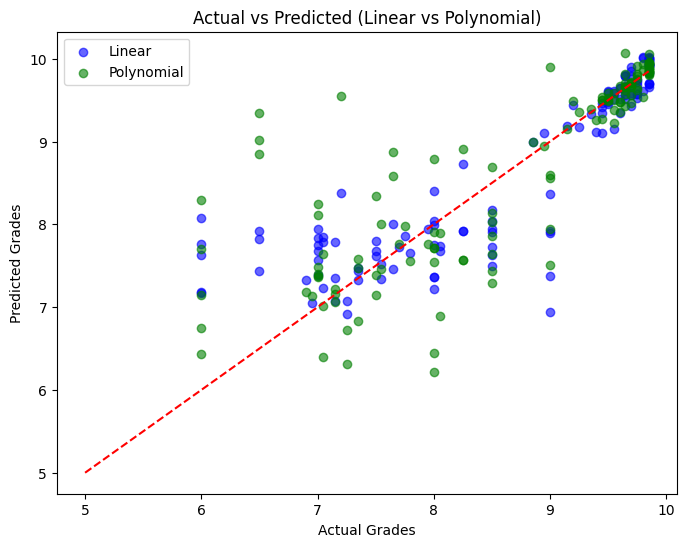

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lin, alpha=0.6, label="Linear", color="blue")
plt.scatter(y_test, y_pred_poly, alpha=0.6, label="Polynomial", color="green")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Grades")
plt.ylabel("Predicted Grades")
plt.title("Actual vs Predicted (Linear vs Polynomial)")
plt.legend()
plt.show()